# Hybrid Images

## Introduction
Hybrid images was proposed in the SIGGRAPH 2006 [paper](https://www.researchgate.net/publication/220184425_Hybrid_images) by Oliva, Torralba, and Schyns. [Here](http://olivalab.mit.edu/hybridimage.htm) is the webpage of their work.

Hybrid images are static images that change in interpretation as a function of the viewing distance. The basic idea is that high frequency tends to dominate perception when it is available, but, at a distance, only the low frequency (smooth) part of the signal can be seen. By blending the high frequency portion of one image with the low-frequency portion of another, you get a hybrid image that leads to different interpretations at different distances.

<img src="hybrid.jpg" style="zoom:100%" />

Low-frequency parts of the image can be understood as "contours", such as the shape of the face. "high attached microdermabrasion" 微晶磨皮

The high-frequency parts of the image can be understood as "details", such as wrinkles and spots on the face.

Therefore, we often say that the low-frequency part of the image is obtained after the image is blurred, and the image is sharpened to make the high-frequency information of the image more.

## Basic steps

The overall idea of the implementation is simple-superimpose a picture with only low-frequency information and an image with only high-frequency information. Specific steps are as follows:

1. Prepare low-frequency filters (usually Gaussian blur filter).
2. Convolution of each dimension of the first image with Gaussian filter.
3. Convolution of each dimension of the second image with Gaussian filter, and subtract the filtered image from the original image to obtain the high-frequency image. ! NOTE that the Gaussian filter in this step may have different standard deviation from the above one. You need to try different values to produce satisfatory results.
4. Add the two processed images to get a hybrid image.

## Implementation details

### 1. Read a pair of images and alignment

Read a pair of images. You can use the the given images for test, but for submission, you have to use your own images. The image pair should be well aligned for satisfatory results. You need to mannualy select two points on each image and calculate the rotation and scaling parameters.

<img src="cat.bmp" style="zoom:60%" /> <img src="dog.bmp" style="zoom:60%" />

For example, the above cat and dog are not aligned. We need to rotate and scale the dog image to align with the cat. We select the centers of the two eyes on the dog image, then we can caculate the rotation angle and the scaling factor.

This method exploys two points on each image. You need to think of appropriate steps to do the alignment. The following steps are just one possible way:

1. Select two points A1 and A2 on image A for alignement; and selcet two points B1 and B2 on image B;

2. Translate image B so that B1 is aligned with A1;

3. Rotate image B to make the line B1B2 have the same direction with line A1A2;

4. Scale image B, so that the distance between B1 and B2 is equal to the distance between A1 and A2;

5. Crop the images to make the two image have the same size.


Please write your code below to align your image pair. Note that, you can use OpenCV functions for rotation and scaling.

1.在图像A上选择两个点A1和A2进行对准；并且在图像B上选择两个点B1和B2； 
2.平移图像B，使得B1与A1对齐； 
3.旋转图像B，使B1B2线与A1A2线方向一致； 
4.缩放图像B，使B1和B2之间的距离等于A1和A2之间的距离； 
5.裁剪图像以使两个图像具有相同的大小

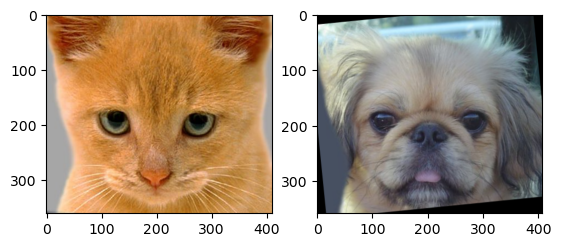

True

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_a = cv2.imread("cat.jpg")
image_b = cv2.imread("dog.jpg")
# for example, the two points on the first image are:
p11 = [100, 200]
p12 = [300, 200]
# and the corresponding two points on the second image are:
p21 = [100, 190]
p22 = [300, 170]

# 计算平移矩阵，使B1与A1对齐
translation_matrix = np.float32([[1, 0, p11[0] - p21[0]], [0, 1, p11[1] - p21[1]]])
image_b_transformed = cv2.warpAffine(image_b, translation_matrix, (image_b.shape[1], image_b.shape[0]))

# 计算旋转角度，使B1B2线与A1A2线方向一致
angle = np.arctan2(p12[1] - p11[1], p12[0] - p11[0]) - np.arctan2(p22[1] - p21[1], p22[0] - p21[0])
rotation_matrix = cv2.getRotationMatrix2D(p21, angle*180/np.pi, 1)
image_b_transformed = cv2.warpAffine(image_b_transformed, rotation_matrix, (image_b.shape[1], image_b.shape[0]))

# 计算缩放比例，使B1和B2之间的距离等于A1和A2之间的距离
scale = np.sqrt((p12[0] - p11[0])**2 + (p12[1] - p11[1])**2) / np.sqrt((p22[0] - p21[0])**2 + (p22[1] - p21[1])**2)
image_b_transformed = cv2.resize(image_b_transformed, None, fx=scale, fy=scale)

# 裁剪图像以使两个图像具有相同的大小
height, width, _ = image_a.shape
image_b_cropped = image_b_transformed[0:height, 0:width]

# 显示结果
fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(image_b_cropped, cv2.COLOR_BGR2RGB))

plt.show()
# 保存或显示结果
cv2.imwrite("image_A.jpg", image_a)
cv2.imwrite("image_B.jpg", image_b)
#cv2.imshow("Image A", image_a)
#cv2.imshow("Image B", image_b)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

### 2. Make Gaussian filters
You need to make your own Gaussian filters even the OpenCV has provided you with some easy to use functions as follows.

In [2]:
# import cv2
# out = cv2.GaussianBlur(in, 0, 4)

When you make your own Gaussian filter, you have to specify the filter size (usually odd number) and the standard deviation. In OpenCV, if the kernerl size is given but the standard deviation $\sigma$ is not given, then $\sigma$ can be determined according to:
$$
\sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
$$
If the $\sigma$ is given but the kernel size is not given, then the kernel size can be se to $6\sigma$ or $8\sigma$ (usually an odd number), as we have discussed in the lecture that $[-3\sigma, 3\sigma]$ of a Gaussian function captures 99.7% of the energy.

This [blog](https://www.cnblogs.com/shine-lee/p/9671253.html) gives a detailed discussion on the selection of kernel size and $\sigma$.

Please finish the following function to generate your Gaussian filter:

**NOTE!!!! The sum of the kernel weights should be 1.**

In [30]:
import numpy as np
def MakeGaussianFilter(kernel_size):
    # 计算高斯滤波器的中心位置
   center = kernel_size // 2
   sigma = 0.3*((kernel_size- 1)*0.5 - 1) + 0.8
   # 生成高斯滤波器模板
   f = np.zeros((kernel_size, kernel_size))
   for i in range(kernel_size):
       for j in range(kernel_size):
             f[i,j] = np.exp(-((i - center)**2 + (j - center)**2) / (2 * sigma**2))

   # 根据总和归一化滤波器权重
   f = f / np.sum(f)
   return f


### 3. Padding your images

We will use zero-padding to keep the filtered image having the same size with the input image. The padding should be half size of your filter kernel. For example, the following figure shows a 3x3 filter and a 5x5 input image. With padding on the top, bottom, left and right with 1 row/column zeros (note, the filter size 3 divided by 2, therefore the padding is 1, 3//2=1), the filtered image has the same size of the input (5x5). If your filter size is, for example 21x21, then the padding should be 10 rows/columns of zeros on each of the 4 boarders.

<img src="zero-padding.png" style="zoom:60%" />

In [31]:
def Padding(im, pad):
    # 获取输入图像的尺寸
    height, width, _ = im.shape

    pad = int(pad)
    # 创建一个新的零矩阵来存储填充后的图像
    im_padded = np.zeros((height + 2*pad, width + 2*pad,3))
    
    # 将输入图像复制到填充后的图像中心
    im_padded[pad:pad+height, pad:pad+width,:] = im
    
    return im_padded

### 4. Convolution

Write your own code for the 2D convolution function. Use a filter to convolve on an image (RGB image).

For just this assignment, you are forbidden from using any Numpy, Scipy, OpenCV, or other preimplemented functions for filtering. You are allowed to use basic matrix operations like np.shape, np.zeros, and np.transpose. This limitation will be lifted in future assignments, but for now, you should use for loops or Numpy vectorization to apply a kernel to each pixel in the image.

In [32]:
def Convolution2D(im, kernel):
    # 获取图像和卷积核的高度和宽度
    image_height, image_width, _ = im.shape
    kernel_height, kernel_width = kernel.shape
    
    # 计算卷积后的图像尺寸
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    print
    
    # 创建一个用于存储卷积后图像的数组
    result = np.zeros((output_height, output_width, 3))
    
    # 对RGB图像的每个通道进行卷积
    for channel in range(3):
        for i in range(output_height):
            for j in range(output_width):
                # 对于每个像素，应用卷积核
                result[i, j, channel] = np.sum(im[i:i+kernel_height, j:j+kernel_width, channel] * kernel)
    
    return result

### 5. Filter your images and make hybrid image

Make a Gaussian filter to convolve on image A, get the blured image A'. Make another Gaussian filter to convolve on image B, and substract the result from the original B, get the detail image B'. Add A' and B' to get the hybrid image.

NOTE! You may have to try different values for the standard deviation in Gaussian filters to get satifactory results.
用高斯滤波器对图像a进行卷积，得到模糊的图像a’。用另一个高斯滤波器对图像B进行卷积，并将结果从原始图像B中减去，得到细节图像B'。添加A'和B'以获得混合图像。

22.0


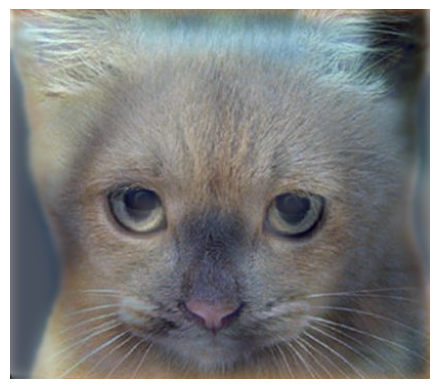

True

In [55]:
# TODO:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 读取图像
image1 = cv2.imread('image_B.jpg')
image2 = cv2.imread('image_A.jpg')

# 计算滤波器的尺寸
filter_size =  45  
padd = (filter_size - 1) / 2
image11 = Padding(image1,padd)
image22 = Padding(image2,padd)
print(padd)

# 创建高斯滤波器
filter = MakeGaussianFilter(filter_size)

# 对图像1应用低通滤波器
low_frequencies = Convolution2D(image11, filter)
# 对图像2应用低通滤波器
high_frequencies = image2 - Convolution2D(image22, filter)

# 计算混合图像（低频部分加高频部分）
hybrid_image = low_frequencies + high_frequencies

# 将图像深度从 CV_64F 转换为 CV_32F
hybrid_image = cv2.normalize(hybrid_image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# 现在可以安全地进行颜色空间转换
hybrid_image_rgb = cv2.cvtColor(hybrid_image, cv2.COLOR_BGR2RGB)

# 显示结果
plt.imshow(hybrid_image_rgb)
plt.axis('off')
plt.show()
# 在当前目录保存结果为jpg文件
cv2.imwrite('low_frequencies.jpg', low_frequencies)
cv2.imwrite('high_frequencies.jpg', high_frequencies)
cv2.imwrite('hybrid_image.jpg', hybrid_image)


### 6. Make Gaussian pyramid to show your hybrid image

Use Gaussian filter to build up a Gaussian pyramid. The lower level image in the pyramid should exhibit high frequency information (details); while the higher level image in the pyramid should exhibit low frequency information.

<img src="hybrid_image_scales.jpg" style="zoom:60%" />

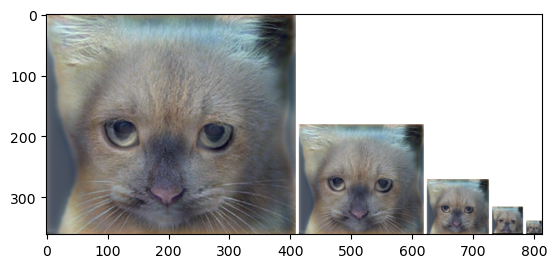

In [59]:
# TODO:
from PIL import Image
import numpy as np
from scipy.ndimage import zoom

def vis_hybrid_image(hybrid_image,filter,padd):
    scales = 5  # 缩小4次
    scale_factor = 0.5  # 每次缩小2倍
    padding = 5  # 填充5个像素用于图片间隔

    original_height = hybrid_image.shape[0]  # 图像的行数
    num_colors = hybrid_image.shape[2]  # 图像的通道数
    output = hybrid_image.copy()
    cur_image = hybrid_image.copy()

    for i in range(2, scales + 1):  # 缩小4次
        # 填充5列像素，白色
        padding_array = np.ones((original_height, padding, num_colors))
        output = np.concatenate((output, padding_array), axis=1)
        #output = Padding(output,padd)
        #output = Convolution2D(output, filter)
        # 下采样
        cur_image = zoom(cur_image, (scale_factor, scale_factor, 1), order=1)
        # 在缩小图的上面填充白色像素
        tmp = np.concatenate((np.ones((original_height - cur_image.shape[0], cur_image.shape[1], num_colors)), cur_image), axis=0)
        # 将前一output和此时缩小图tmp按行合并
        output = np.concatenate((output, tmp), axis=1)
        plt.imshow(output)

    return output

# Convert the image to a numpy array
hybrid_image_array = np.array(hybrid_image_rgb)

# Call the function with the image array
output_image = vis_hybrid_image(hybrid_image_array,filter,padd)

## References

0. The origianl authors' project page. http://olivalab.mit.edu/hybridimage.htm
1. A Tutorial. https://jeremykun.com/2014/09/29/hybrid-images/
2. Chinese blog，matlab code, with alignment。 https://blog.csdn.net/breeze_blows/article/details/102962559
3. Matlab code. https://github.com/coldmanck/Image-Filtering-and-Hybrid-Images
4. Soton University. http://comp3204.ecs.soton.ac.uk/cw/coursework2.html
5. Brown University. http://cs.brown.edu/courses/cs143/2011/ and the project http://cs.brown.edu/courses/cs143/2011/proj1/
6. Python implementation with GUI. https://github.com/ReynoldZhao/Hybrid_Images
7. George Washington University, student's homework. https://blog.csdn.net/Sengo_GWU/article/details/79336511
8. Georgia Institute of Technology, student's homework. https://github.com/all4win/Computer_Vision_Proj1_Image_Filtering_and_Hybrid_Images and https://www.cc.gatech.edu/classes/AY2016/cs4476_fall/results/proj1/html/jwei74/index.html
9. 电子科大的学生作业. https://blog.csdn.net/sinat_41942180/article/details/107972994
10. 比较详细的中文博客文章，Matlab代码. https://blog.csdn.net/weixin_45901986/article/details/104823057
11. 英国南安普顿大学的博士研究生的知乎文章. https://zhuanlan.zhihu.com/p/106619097
12. Washington University in St. Louis. Student's project. https://sites.google.com/site/cse559acomputervisionprojects/home/project-1-hybrid-images